In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

dados = pd.read_csv('/kaggle/input/rio-de-janeiro-airbnb-listings-2022/AirbnbRJRentals.csv')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28301 entries, 0 to 28300
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              28301 non-null  int64  
 1   name                            28272 non-null  object 
 2   host_id                         28301 non-null  int64  
 3   host_name                       28298 non-null  object 
 4   neighbourhood                   28301 non-null  object 
 5   latitude                        28301 non-null  float64
 6   longitude                       28301 non-null  float64
 7   room_type                       28301 non-null  object 
 8   price                           28301 non-null  int64  
 9   minimum_nights                  28301 non-null  int64  
 10  number_of_reviews               28301 non-null  int64  
 11  last_review                     19783 non-null  object 
 12  reviews_per_month               

Uma vez que os mesmos valores faltantes de host_id e host_name estão inclusos nos faltantes last_review e review_per_month, e que review_per_month pode ser interessante à analise, uma exclusão das linhas nulas foi realizada.

# Examinando ponto de recorte através dos Decis

In [2]:
dados_limpos = dados.dropna()
dados_limpos.select_dtypes('int64').describe().drop(columns={'id', 'host_id'})

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,19781.000000,19781.000000,19781.000000,19781.000000,19781.000000,19781.000000
mean,1208.160710,3.959001,25.040898,8.602497,190.993529,8.808453
std,7355.949295,20.428644,43.059332,24.374662,131.770325,11.802266
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,300.000000,2.000000,3.000000,1.000000,65.000000,1.000000
50%,557.000000,2.000000,9.000000,2.000000,176.000000,4.000000
75%,971.000000,3.000000,27.000000,4.000000,329.000000,12.000000
max,500000.000000,999.000000,563.000000,228.000000,365.000000,174.000000


In [3]:
def consulta_deciles():
    deciles = pd.DataFrame(dados_limpos.select_dtypes('int64').quantile([0.1 * i for i in range(1, 11)]))
    deciles.drop(columns={'id', 'host_id'}, inplace=True)
    return deciles

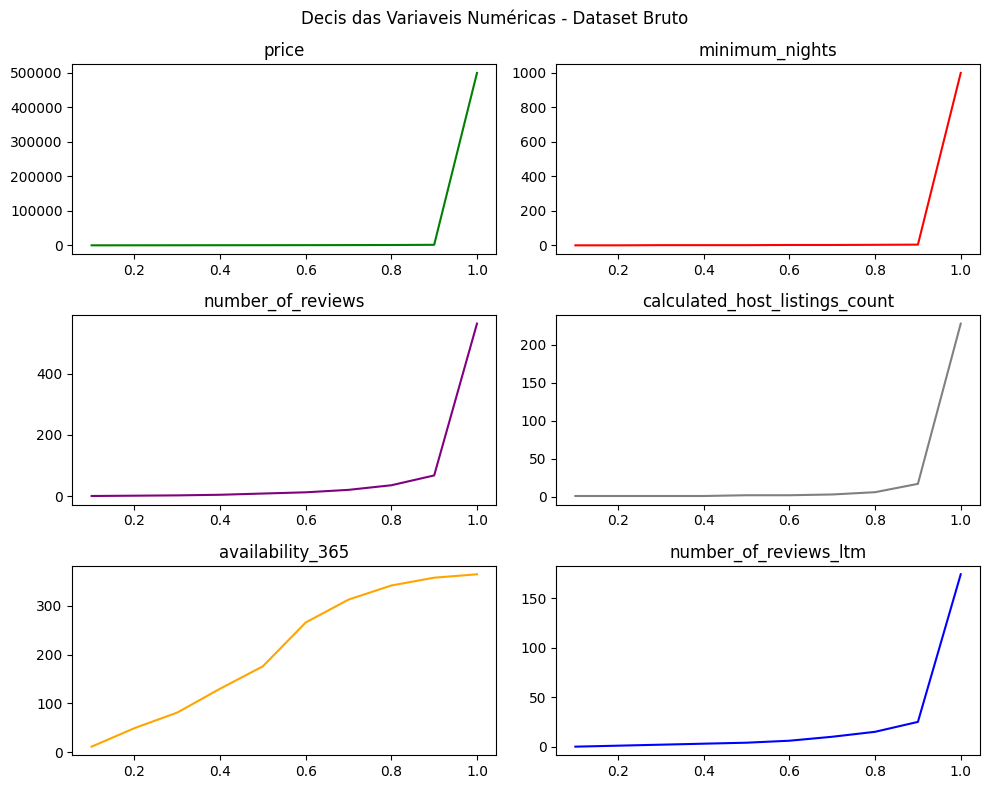

In [4]:
deciles = consulta_deciles()

fig, ax = plt.subplots(ncols=1, sharey = False, figsize = (10, 8))

cores = ['green','red', 'purple', 'gray', 'orange', 'blue']
for d in range(0, len(deciles.columns)):
    plt.subplot(3, 2, d+1)
    plt.plot(deciles[list(deciles.columns)[d]], color=cores[d])
    plt.title(list(deciles.columns)[d])
    
fig.suptitle('Decis das Variaveis Numéricas - Dataset Bruto')
plt.tight_layout()

# Recorte de Dados pelo nono Decil

In [5]:
consulta_deciles()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm
0.1,170.0,1.0,1.0,1.0,11.0,0.0
0.2,254.0,1.0,2.0,1.0,49.0,1.0
0.3,350.0,2.0,3.0,1.0,81.0,2.0
0.4,450.0,2.0,5.0,1.0,130.0,3.0
0.5,557.0,2.0,9.0,2.0,176.0,4.0
0.6,693.0,3.0,13.0,2.0,266.0,6.0
0.7,853.0,3.0,21.0,3.0,313.0,10.0
0.8,1103.0,4.0,36.0,6.0,342.0,15.0
0.9,1671.0,5.0,68.0,17.0,358.0,25.0
1.0,500000.0,999.0,563.0,228.0,365.0,174.0


Corte nos de mais interesse

In [6]:
dados_limpos = dados_limpos[dados_limpos.price <= deciles.iloc[-2][0]]
dados_limpos = dados_limpos[dados_limpos.number_of_reviews <= deciles.iloc[-2][2]]
dados_limpos = dados_limpos[dados_limpos.number_of_reviews_ltm <= deciles.iloc[-2][5]]
dados_limpos = dados_limpos[dados_limpos.minimum_nights <= deciles.iloc[-2][1]]
# dados_limpos.describe()

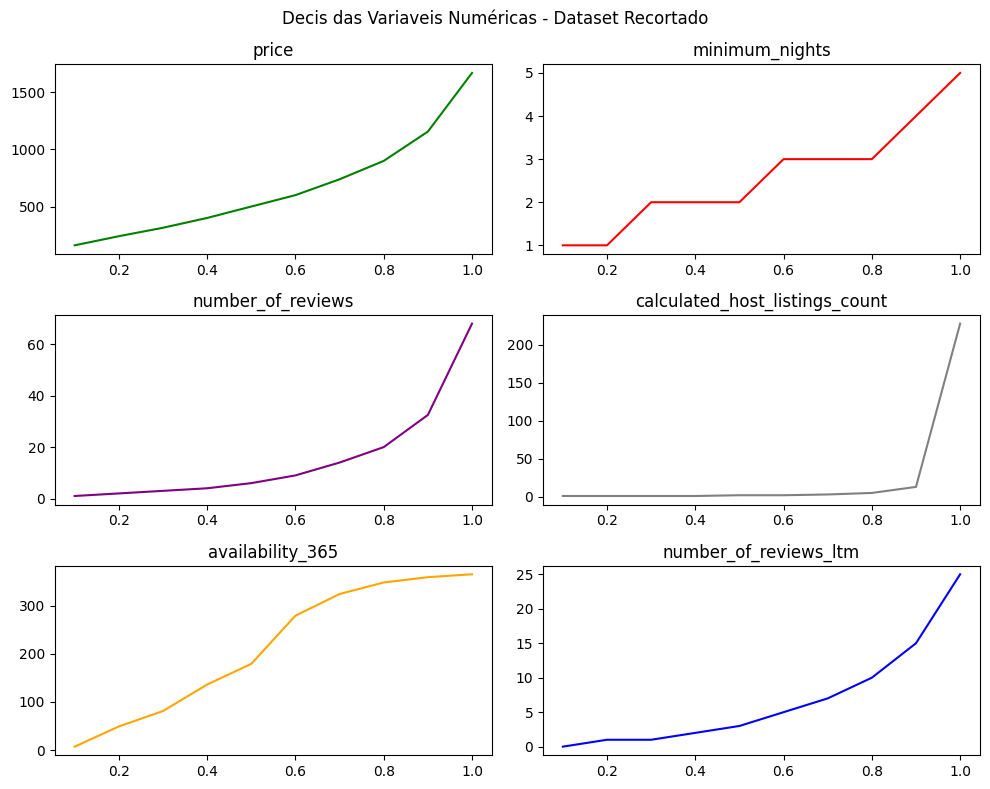

In [7]:
deciles = consulta_deciles()
fig, ax = plt.subplots(ncols=1, sharey = False, figsize = (10, 8))

for d in range(0, len(deciles.columns)):
    plt.subplot(3, 2, d+1)
    plt.plot(deciles[list(deciles.columns)[d]], color=cores[d])
    plt.title(list(deciles.columns)[d])
    
fig.suptitle('Decis das Variaveis Numéricas - Dataset Recortado')
plt.tight_layout()

Visualização de distribuição e tendencia central

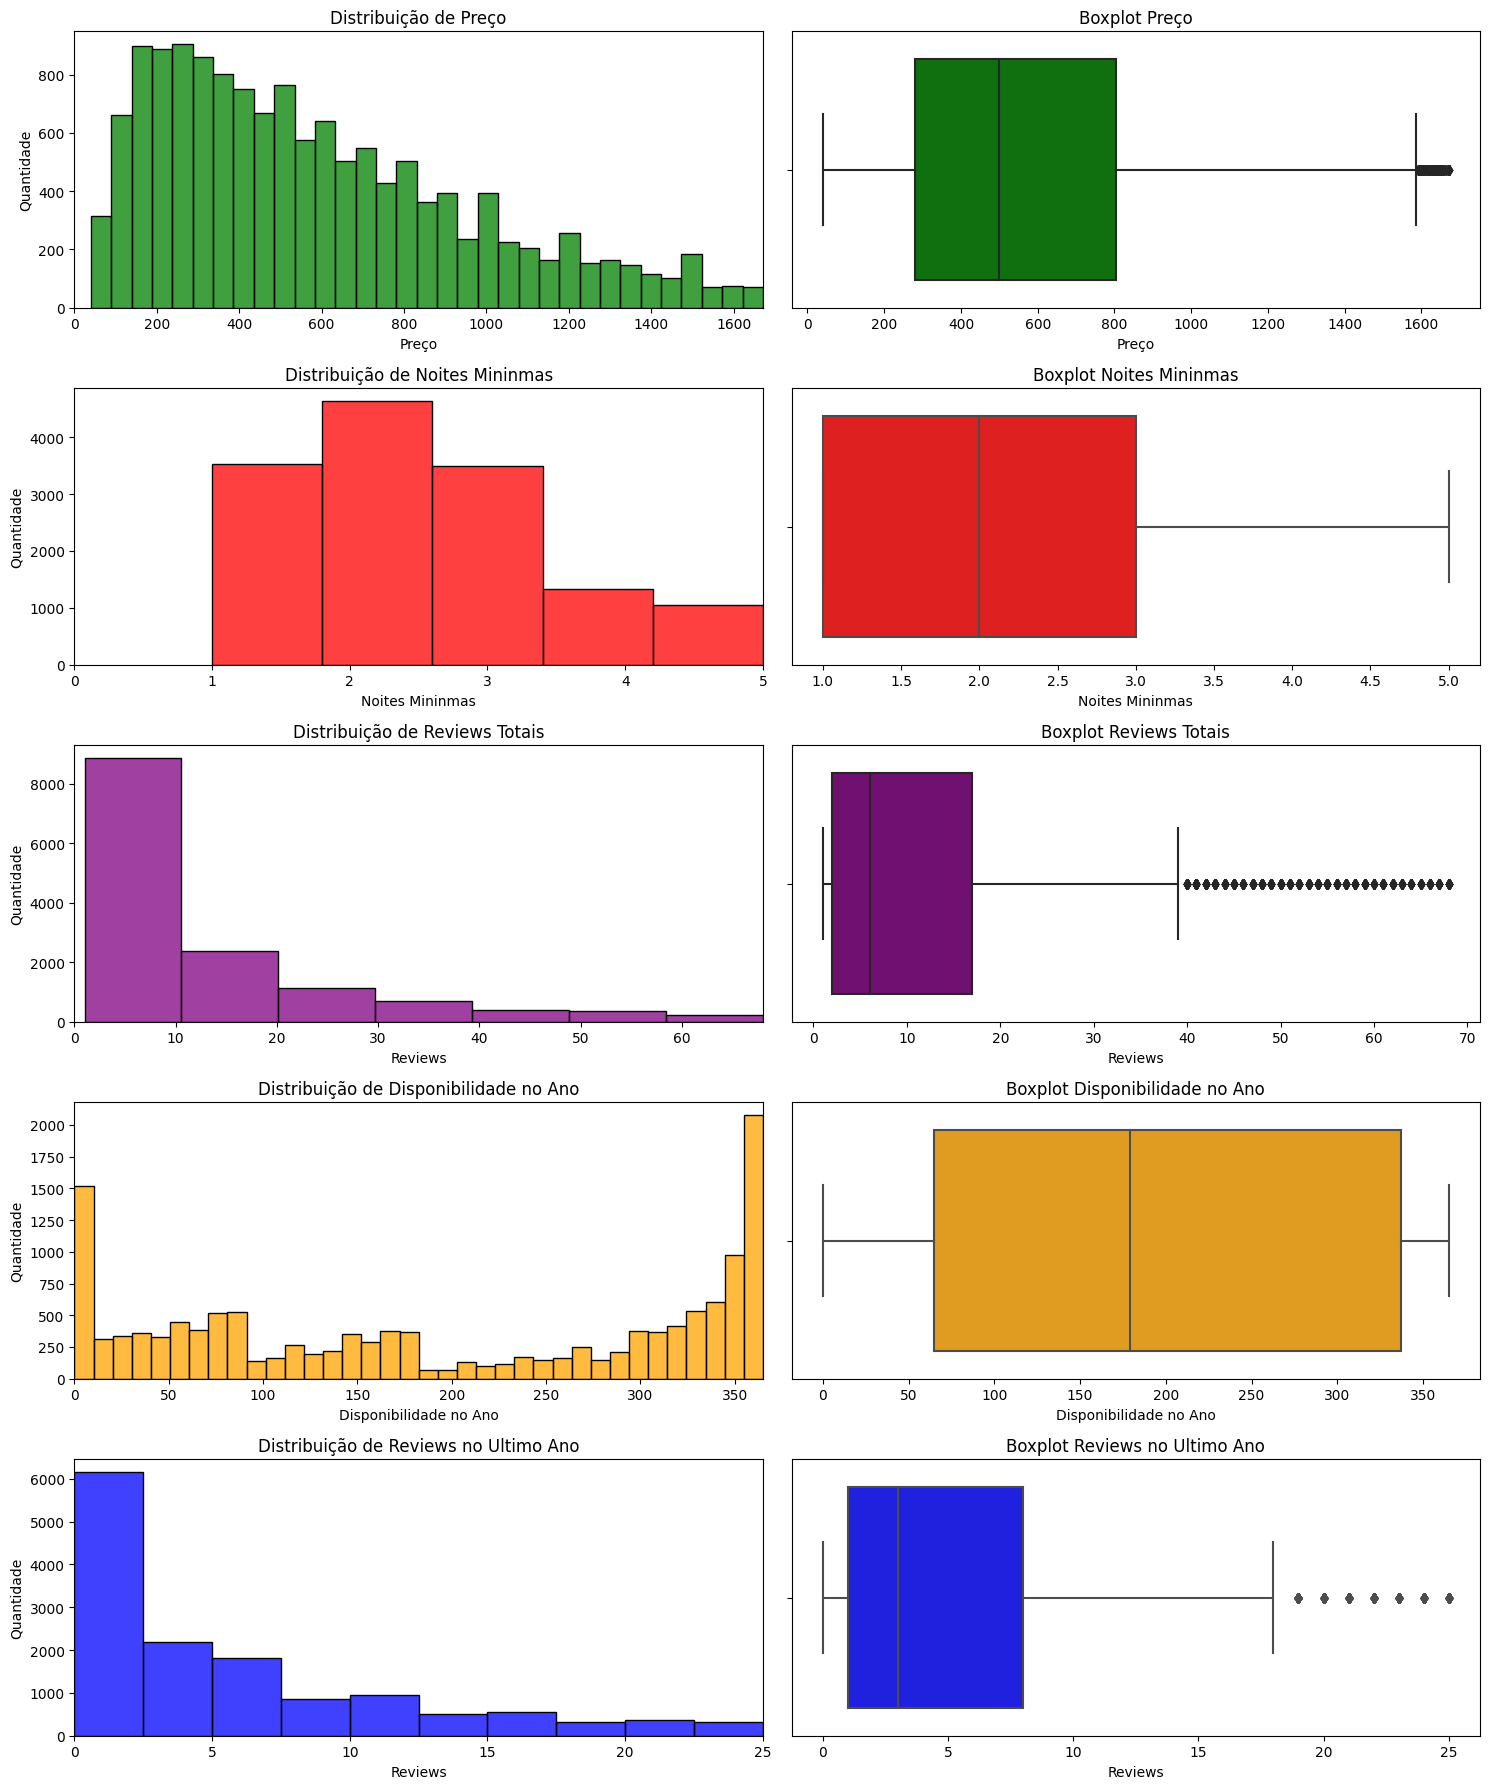

In [8]:
dados_num = dados_limpos.drop(columns={'id','host_id','latitude','longitude'})
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(ncols = 2, nrows=5, sharey = False, figsize = (15, 18))

sns.histplot(dados_num['price'], kde = False, color=cores[0], ax = ax1, bins= 33) # intervalos de tamanho 50.6
ax1.grid(False)
ax1.set_title('Distribuição de Preço')
ax1.set_ylabel('Quantidade')
ax1.set_xlabel('Preço')
ax1.set_xlim(0, dados_num.price.max())

sns.boxplot(x=dados_num['price'], ax = ax2, color=cores[0])
ax2.grid(False)
ax2.set_xlabel('Preço')
ax2.set_title('Boxplot Preço')
plt.tight_layout()

sns.histplot(dados_num['minimum_nights'], kde = False, color=cores[1], ax = ax3, bins= 5) # intervalos de tamanho 1
ax3.grid(False)
ax3.set_title('Distribuição de Noites Mininmas')
ax3.set_ylabel('Quantidade')
ax3.set_xlabel('Noites Mininmas')
ax3.set_xlim(0, dados_num.minimum_nights.max())

sns.boxplot(x=dados_num['minimum_nights'], ax = ax4, color=cores[1])
ax4.grid(False)
ax4.set_xlabel('Noites Mininmas')
ax4.set_title('Boxplot Noites Mininmas')
plt.tight_layout()

sns.histplot(dados_num['number_of_reviews'], kde = False, color=cores[2], ax = ax5, bins= 7) # intervalos de tamanho 9.7
ax5.grid(False)
ax5.set_title('Distribuição de Reviews Totais')
ax5.set_ylabel('Quantidade')
ax5.set_xlabel('Reviews')
ax5.set_xlim(0, dados_num.number_of_reviews.max())

sns.boxplot(x=dados_num['number_of_reviews'], ax = ax6, color=cores[2])
ax6.grid(False)
ax6.set_xlabel('Reviews')
ax6.set_title('Boxplot Reviews Totais')
plt.tight_layout()

sns.histplot(dados_num['availability_365'], kde = False, color=cores[4], ax = ax7, bins= 36) # intervalos de tamanho 10.1
ax7.grid(False)
ax7.set_title('Distribuição de Disponibilidade no Ano')
ax7.set_ylabel('Quantidade')
ax7.set_xlabel('Disponibilidade no Ano')
ax7.set_xlim(0, dados_num.availability_365.max())

sns.boxplot(x=dados_num['availability_365'], ax = ax8, color=cores[4])
ax8.grid(False)
ax8.set_xlabel('Disponibilidade no Ano')
ax8.set_title('Boxplot Disponibilidade no Ano')
plt.tight_layout()

sns.histplot(dados_num['number_of_reviews_ltm'], kde = False, color=cores[5], ax = ax9, bins= 10) # intervalos de tamanho 50.6
ax9.grid(False)
ax9.set_title('Distribuição de Reviews no Ultimo Ano')
ax9.set_ylabel('Quantidade')
ax9.set_xlabel('Reviews')
ax9.set_xlim(0, dados_num.number_of_reviews_ltm.max())

sns.boxplot(x=dados_num['number_of_reviews_ltm'], ax = ax10, color=cores[5])
ax10.grid(False)
ax10.set_xlabel('Reviews')
ax10.set_title('Boxplot Reviews no Ultimo Ano')
plt.tight_layout()

In [9]:
dados_num = pd.concat([dados_num, pd.get_dummies(dados_num['room_type'], dtype='int')], axis=1)
dados_num.drop(columns={'name', 'host_name', 'neighbourhood', 'room_type', 'last_review'}, inplace=True)
dados_num

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,Entire home/apt,Hotel room,Private room,Shared room
0,581,1,2,0.03,6,181,0,1,0,0,0
3,599,4,1,0.26,4,363,1,0,0,1,0
6,657,2,2,0.55,1,241,2,1,0,0,0
10,500,1,17,0.42,1,90,0,0,0,1,0
16,1293,3,4,1.03,7,62,4,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
28288,1264,2,4,1.11,1,255,4,1,0,0,0
28289,1500,1,11,1.19,107,262,11,1,0,0,0
28292,1200,2,36,0.63,3,54,11,1,0,0,0
28296,871,3,1,0.27,1,365,1,1,0,0,0


Text(0.5, 1.0, 'Matriz de Correlação')

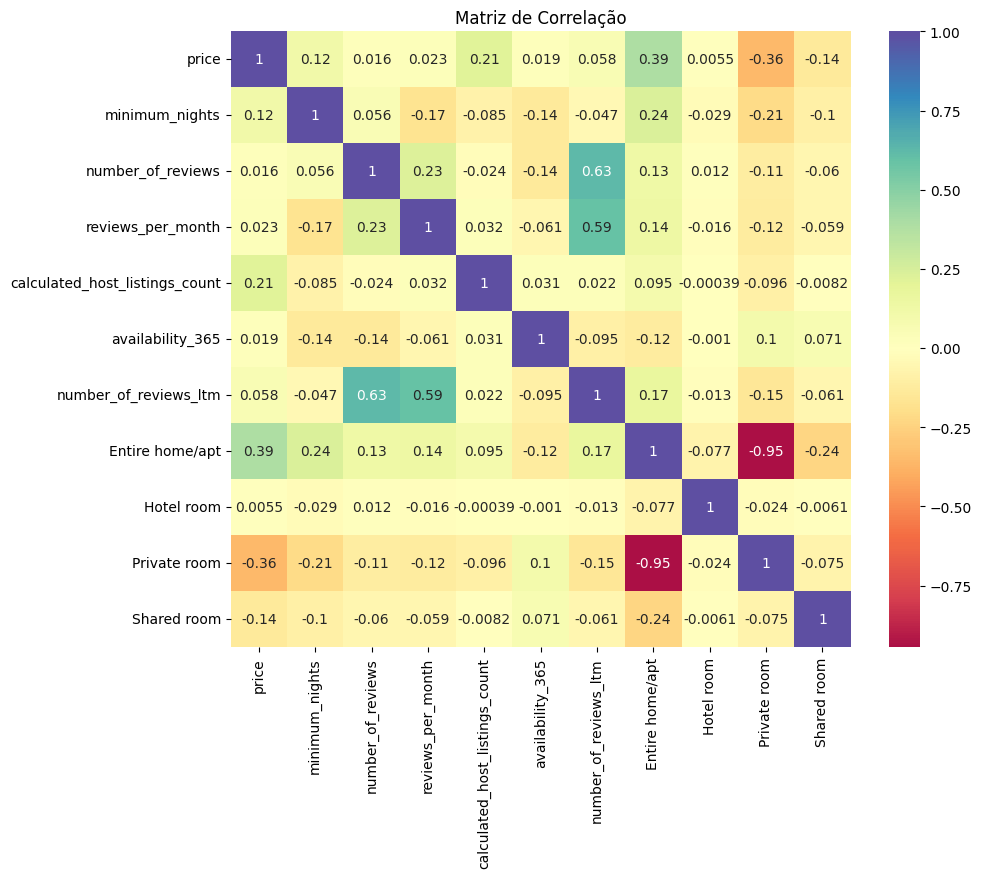

In [10]:
matrix = dados_num.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, cmap='Spectral', center=0)
plt.title('Matriz de Correlação')

In [11]:
matrix.sort_values(by='price', ascending=False)['price']

price                             1.000000
Entire home/apt                   0.391750
calculated_host_listings_count    0.210066
minimum_nights                    0.118459
number_of_reviews_ltm             0.058216
reviews_per_month                 0.023299
availability_365                  0.019314
number_of_reviews                 0.015590
Hotel room                        0.005476
Shared room                      -0.136468
Private room                     -0.360264
Name: price, dtype: float64

In [12]:
price1 = matrix.sort_values(by='price', ascending=False)[matrix.price >= 0.1]['price']
price2 = matrix.sort_values(by='price', ascending=False)[matrix.price <= -0.1]['price']
pd.concat([price1, price2], axis=0)

price                             1.000000
Entire home/apt                   0.391750
calculated_host_listings_count    0.210066
minimum_nights                    0.118459
Shared room                      -0.136468
Private room                     -0.360264
Name: price, dtype: float64

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols = 2, nrows=2, sharey = False, figsize = (15, 8))

hist = sns.histplot(x=dados_limpos[dados_limpos.number_of_reviews_ltm < 25]['number_of_reviews_ltm'], y=dados_limpos['price'], 
             kde = False, color='blue', ax = ax1, 
             bins= 5) # intervalos de tamanho 17
        
ax1.grid(False)
ax1.set_title('Relação Avaliações x Preço')
ax1.set_ylabel('Preço')
ax1.set_xlabel('Quantidade de Avaliações')
ax1.set_xlim(0, 25)

sns.scatterplot(x=dados_limpos['number_of_reviews_ltm'], y=dados_limpos['price'], color='blue', ax=ax2)
plt.title('Relação Avaliações x Preço',)
plt.xlabel('Quantidade de Avaliações')
plt.ylabel('Preço')

sns.histplot(x=dados_limpos['number_of_reviews_ltm'], y=dados_limpos['availability_365'], 
             kde = False, color='pink', ax = ax3, 
             bins= int(dados_limpos.number_of_reviews_ltm.max()/10)) # intervalos de tamanho 17
ax3.grid(False)
ax3.set_title('Relação Avaliações x Disponibilidade')
ax3.set_ylabel('Disponibilidade no ano')
ax3.set_xlabel('Quantidade de Avaliações')
ax3.set_xlim(0, dados_limpos.number_of_reviews_ltm.max())

plt.tight_layout()

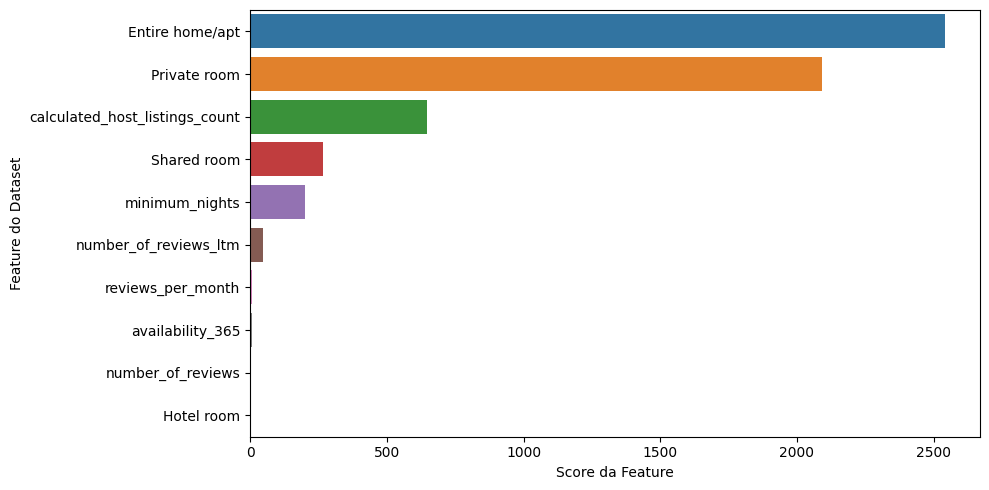

In [61]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=1).fit(dados_num.drop(columns={'price'}), dados_num['price'])
scores = pd.DataFrame(columns=['cols', 'scores'])
scores['cols'] = dados_num.columns[1:]
scores['scores'] = selector.scores_

plt.figure(figsize=(10, 5))
sns.barplot(scores.sort_values(by='scores', ascending=False), y='cols', x='scores')
plt.xlabel('Score da Feature')
plt.ylabel('Feature do Dataset')
plt.tight_layout()

É claro que Hotel room é uma variavel pouco correlata, de 28 mil registros dos dados originais, apenas 53 são 'Hotel room'

In [66]:
dados[dados.room_type == 'Hotel room'].count()

id                                53
name                              53
host_id                           53
host_name                         53
neighbourhood                     53
latitude                          53
longitude                         53
room_type                         53
price                             53
minimum_nights                    53
number_of_reviews                 53
last_review                       45
reviews_per_month                 45
calculated_host_listings_count    53
availability_365                  53
number_of_reviews_ltm             53
dtype: int64

In [63]:
dados_num.sum()

price                             8151184.00
minimum_nights                      33821.00
number_of_reviews                  170968.00
reviews_per_month                    9871.13
calculated_host_listings_count      95459.00
availability_365                  2742243.00
number_of_reviews_ltm               78282.00
Entire home/apt                     10518.00
Hotel room                             28.00
Private room                         3221.00
Shared room                           259.00
dtype: float64